# **COMP 2211 Exploring Artificial Intelligence**
## Image Classification (CNN)

![cnn.png](https://miro.medium.com/max/1400/1*irWQaiIjHS27ZAPaVDoj6w.png)

## **Review** ##
Before we start, let's have a quick recap of the lecture. We will go through the recap using the FashionMINIST dataset as an example.

As we will train a CNN model on FashionMINIST, let's first enable GPU acceleration to speed up the training process.

**Enable the GPU accelerator in Colab:**

1. 'Edit' -> 'Notebook settings':

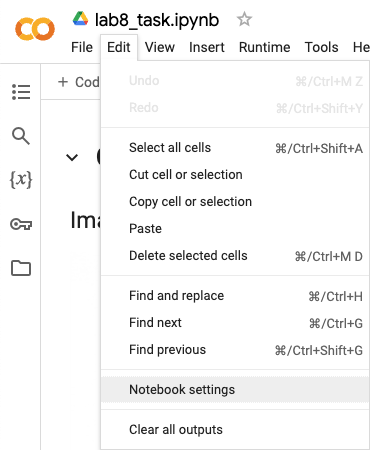

2. Set 'Hardware accelerator' to GPU:

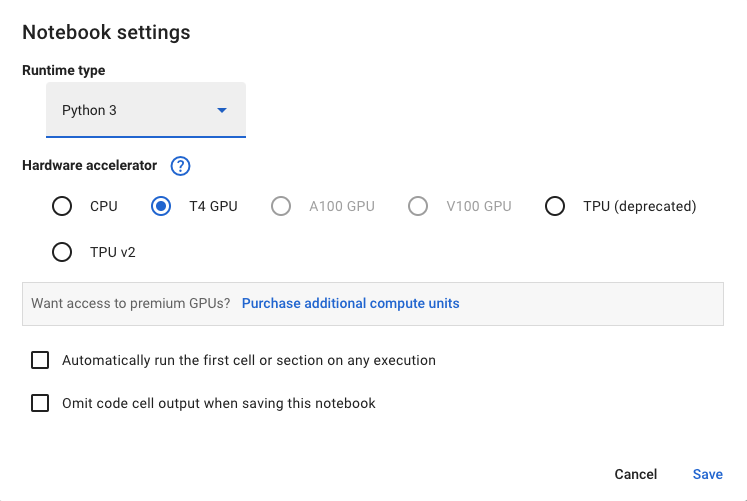

## Check if gpu is enabled

In [ ]:
# Import pytorch library
import torch

GPU_IS_AVAILABLE = torch.cuda.is_available()    # check if gpu is available in your environment
print(GPU_IS_AVAILABLE)                         # CUDA is available and can be used when it is True

True


In [ ]:
# check your Colab device
!nvidia-smi

Thu Feb 27 23:41:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

***Note:*** If you use the GPU too regularly, runtime durations will become shorter and shorter, and disconnections will become more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

## The procedure of training a CNN for image classification

1. Import required libraries and define global variables
2. Data preprocessing
3. Build the model
4. Compile the model
5. Train the model
6. Evaluate the model
7. Save the model

## 1. Import required libraries and define global variables

In [ ]:
%matplotlib inline
import os                                                              # Import os
import numpy as np                                                     # Import numpy library
import matplotlib.pyplot as plt                                        # Import mathplot library
import tqdm                                                            # Import tqdm library
import torch.nn as nn                                                  # Import Base class which provides a collection of neural network layers, functions, and modules
import torch.nn.functional as F                                        # import functional tool library for many operations commonly used in neural networks
import torchvision                                                     # Import torchvision library
import torchvision.transforms as transforms                            # import data preprocessing tools from torchvision
import datetime                                                        # Import datetime library

## Single step of convolution

<center><img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%201/images/Convolution_schematic.gif?raw=true" style="width:500px;height:300px;"></center>
<caption><center> <u> <font color='white'> Figure 1 </u><font color='white'>  : Convolution operation<br> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left represents a single pixel value. We perform convolution on the image by using a 3x3 filter. This involves multiplying the filter values element-wise with the corresponding values in the original matrix, summing the results, and then adding a bias. In this first step of the exercise, you will implement a single convolution step, which means applying the filter to just one position to obtain a single real-valued output.

The formulas relating the output shape of the convolution to the input shape are:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$
$$ f = \text{kernel size}$$

## 2. Data Preprocessing

Pytorch provides a convenient interface for loading the FashionMNIST dataset. We can simply use it to load the dataset.

In [ ]:
#Data preprocessing tool
transform = transforms.Compose(
    [transforms.ToTensor(),                   # Converts a PIL Image or numpy.ndarray to torch.FloatTensor
    transforms.Normalize((0.5,), (0.5,))])    # Normalize a tensor image with transforms.Normalize(mean, standard deviation)


# Load FashionMNIST dataset
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.58MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.95MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


Let’s visualize the FashionMINIST data as a sanity check

Dress  Coat  Pullover  Sandal


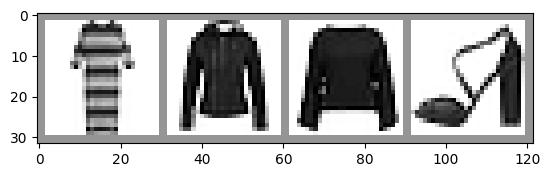

In [ ]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## 3. Build the Model

CNN consists of three main types of layers: **Convolutional (Conv) Layer**, **Pooling Layer**, and **Fully Connected (FC) Layer**

> General Pipeline of CNN: Input -> **Conv Layers** and **Pooling Layers** -> Flatten Operation -> **FC Layers** -> Output

### Convolutional Layer
- Convolution
- Activation

### Pooling Layer
- Max Pooling, Average Pooling, etc.

### FC Layer
- Linear Layer
- Activation

### Other Layers
- Dropout Layer
- ...

There are two ways to build a sequential CNN model in Keras:


In [ ]:
# Create the model
# PyTorch models inherit from torch.nn.Module
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)             # Flatten Operation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Network()

In [ ]:
print(model)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 4. Loss Function
For this example, we'll use cross-entropy loss. To demonstrate how it works, we'll generate batches of dummy output and label values, pass them through the loss function, and take a look at the results.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[6.5397e-01, 5.4914e-01, 4.6800e-01, 8.6551e-01, 2.3380e-01, 2.9600e-01,
         4.3698e-01, 9.6342e-01, 1.7976e-01, 7.9243e-01],
        [5.4021e-01, 1.4566e-01, 7.0647e-01, 9.4553e-01, 9.0849e-04, 5.2723e-01,
         5.6244e-01, 5.1801e-01, 2.0701e-01, 7.1626e-01],
        [6.3128e-01, 4.3757e-02, 9.6080e-01, 2.3123e-02, 9.4204e-01, 9.5784e-01,
         8.2994e-01, 4.8904e-01, 7.3993e-01, 4.0402e-01],
        [8.4423e-01, 2.9646e-01, 6.9994e-01, 8.5765e-01, 7.6895e-01, 1.2139e-01,
         3.8452e-01, 9.7345e-01, 5.8103e-01, 2.7606e-01]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3777499198913574


## 5. Optimizer
For this example, we'll use Adam Optimizer with a learning rate of 0.001.

The Adam optimizer is a popular adaptive learning rate optimization algorithm widely used in deep learning due to its efficiency and effectiveness. It combines the benefits of two other optimization algorithms: Momentum and RMSProp

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. Train the Model

The general structure of the training loop is as follows:



1.   Gets a batch of training data from the DataLoader
2.   Zeros the optimizer’s gradients
3.   Performs an inference - that is, gets predictions from the model for an input batch
4.   Calculates the loss for that set of predictions vs. the labels on the dataset
5.   Calculates the backward gradients over the learning weights
6.   Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
7.   It reports on the loss for every X number of batches (in this case, 1000).
8.   Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run



In [ ]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            running_loss = 0.

    return last_loss

In [ ]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.
pbar = tqdm.tqdm(range(EPOCHS), initial=0, dynamic_ncols=True, smoothing=0.01)

for epoch in pbar:

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    pbar.set_description(
                (
                    f"EPOCH {epoch_number + 1}: LOSS train {avg_loss:.6f} ; LOSS valid {avg_vloss:.6f};"
                )
            )


    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

## 7. Evaluate the Model Performance

In [ ]:
model.eval()
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  for data in validation_loader:
    inputs, labels = data
    # calculate output by running through the network
    outputs = model(inputs)
    # get the predictions
    __, predicted = torch.max(outputs, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(validation_loader)} validation data: {100 * correct / total:.4f} %')

## 8. Save the Model

In [ ]:
#create a folder for saving model
PATH = "./ckpts"
os.makedirs(PATH, exist_ok=True)

# Save the mdoel to a .pth file
torch.save(model.state_dict(), f"{PATH}/model.pth")

## An Interesting Website for CNN Visualization
> https://poloclub.github.io/cnn-explainer/

![web.gif](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_overview_demo.gif)